In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn

In [2]:
# convert raw .dat file to  csv using curate_db.py
# file has to exist in db/udb_1yr.dat
# ! python curate_db.py 

In [3]:
all_dat = pd.read_csv('./curated.csv', index_col=0)

# sift out pwrs
all_dat = all_dat.loc[all_dat['reactor_type'] == 'PWR']  

# separate training and testing set
row_num = all_dat.shape[0]
cutoff = int(row_num * 0.6)
train_dat = all_dat.iloc[:cutoff, :]
test_dat = all_dat.iloc[cutoff:, :]

In [4]:
# get all the isotopes, sorted by A
def get_name(f):
    z = ''
    for i in f:
        if i.isalpha():
            z += i
    return z

def get_a(f):
    z = ''
    for i in f:
        if i.isdigit():
            z += i
    return int(z)

iso_list = list(train_dat)[3:]
# set the isotopes to categories:
fp = []
bred_fissile = []
u235 = []
nottru = []
tru = []

for iso in iso_list:
    if iso == 'u-235':
        u235.append(iso)
    elif iso in ['pu-239', 'u-233']:
        bred_fissile.append(iso)
    elif get_a(iso) < 200:
        fp.append(iso)
    elif get_name(iso) in ['np', 'pu', 'am', 'cm']:
        tru.append(iso)
    else:
        nottru.append(iso)

category = {'u235': u235,
            'bred_fissile': bred_fissile,
            'fp': fp,
            'tru': tru,
            'nottru': nottru}

print(category)

{'u235': ['u-235'], 'bred_fissile': ['pu-239', 'u-233'], 'fp': ['zr-95', 'zr-93', 'ru-103', 'ru-106', 'sb-124', 'sb-125', 'nb-95', 'pd-107', 'pm-147', 'i-129', 'h-3', 'kr-85', 'nb-94', 'cs-134', 'cs-135', 'eu-152', 'cs-137', 'eu-154', 'eu-155', 'ag-108m', 'ag-110m', 'c-14', 'ce-144', 'y-90', 'tc-99', 'sm-151', 'se-79', 'sr-90', 'sn-126'], 'tru': ['pu-238', 'np-237', 'pu-240', 'pu-241', 'pu-244', 'pu-242', 'cm-248', 'cm-245', 'cm-244', 'cm-246', 'cm-247', 'am-241', 'am-243', 'cm-243', 'cm-242'], 'nottru': ['ra-226', 'pa-231', 'am-242m', 'cf-251', 'cf-249', 'ac-227', 'u-234', 'u-236', 'u-238', 'th-229', 'th-232', 'th-230', 'u-232']}


In [11]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model


def lin_least_square(xtrain, ytrain, xtest, ytest):
    ols = linear_model.LinearRegression()
    lin_model = ols.fit(xtrain, ytrain)
    lin_err = np.abs((ytest - lin_model.predict(xtest)) / ytest)
    return lin_err
    
def ann(xtrain, ytrain, xtest, ytest, hidden_layer=2, node_per_layer=8):
    modl = Sequential()
    modl.add(Dense(node_per_layer, kernel_initializer='normal', input_dim=np.shape(xtrain)[1], activation='relu'))
    
    # hidden layer
    for k in range(hidden_layer):
        modl.add(Dense(node_per_layer, kernel_initializer='normal', activation='relu'))
    
    try:
        out_num = np.shape(ytest)[1]
    except:
        out_num = 1
    modl.add(Dense(out_num, kernel_initializer='normal', activation='linear'))

    modl.compile(loss='mean_absolute_error', optimizer='adam',
                 metrics=['mean_absolute_percentage_error'])

    # train it
    modl.fit(xtrain, ytrain, validation_split=0.2)
    prediction = modl.predict(xtest)
    err = np.abs((ytest - prediction) / ytest)
    return err

def ridge(xtrain, ytrain, xtest, ytest, a=0.5):
    
    rd = linear_model.Ridge(alpha=a)
    ridge_model = rd.fit(xtrain, ytrain)
    ridge_err = np.abs((ytest - ridge_model.predict(xtest)) / ytest)
    return ridge_err

def random_forest(xtrain, ytrain, xtest, ytest,
                  estimators=1000, state=42):    
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = estimators, random_state = state)

    # Train the model on training data
    rf.fit(xtrain, ytrain)
    rf_err = ((ytest - rf.predict(xtest)) / ytest)
    return rf_err

def logistic(xtrain, ytrain, xtest, ytest,
             state=0, solver_='lbfgs'):
    model = linear_model.LogisticRegression(multi_class='multinomial').fit(xtrain, ytrain)
    err = ((ytest - model.predict(xtest)) / ytest)
    return err

def lasso(xtrain, ytrain, xtest, ytest, a=0.1):
    model = linear_model.Lasso(alpha=a).fit(xtrain, ytrain)
    print(np.shape(xtest))
    err = ((ytest - model.predict(xtest) / ytest))
    return err

    
    

In [13]:
# for every single isotope:
#    fit: linear, polynomial (n=2), and a combination
#    see which one fits best

x_train = train_dat[['init_enr', 'bu']].as_matrix()
x_test = test_dat[['init_enr', 'bu']].as_matrix()

err_dict = {}
iso_err_dict = {}
for iso in iso_list:
    print(iso)
    y_train = np.asarray(train_dat[iso])
    y_test = np.asarray(test_dat[iso])
    
    err_dict['linear_least_square'] = lin_least_square(x_train, y_train, x_test, y_test)
    err_dict['ridge'] = ridge(x_train, y_train, x_test, y_test)
    err_dict['random forest'] = random_forest(x_train, y_train, x_test, y_test)
    err_dict['lasso'] = lasso(x_train, y_train, x_test, y_test)
    # err_dict['logistic'] = logistic(x_train, y_train, x_test, y_test)
    err_dict['ann'] = ann(x_train, y_train, x_test, y_test)
    mean_err_dict = {}
    for key, val in err_dict.items():
        mean_err_dict[key] = np.abs(np.mean(val))
    
    chosen_alg = min(mean_err_dict, key=mean_err_dict.get)
    print(chosen_alg)
    err = err_dict[chosen_alg]
    iso_err_dict[iso] = np.mean(err)
    print(np.mean(err))
    
    plt.scatter(x_test[:,0], x_test[:,1], c=err)
    plt.xlabel('Enrichment')
    plt.ylabel('Burnup')
    plt.colorbar()
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()


/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


zr-95
(42047, 2)
Train on 50456 samples, validate on 12614 samples
Epoch 1/1
50456/50456 [==============================] - 6s 126us/step - loss: 0.0165 - mean_absolute_percentage_error: 1394145.0801 - val_loss: 3.6899e-04 - val_mean_absolute_percentage_error: 29606.0230


MemoryError: 

In [7]:
for key, val in category.items():
    err_list = []
    for iso in val:
        err_list.append(iso_err_dict[iso])
        if iso_err_dict[iso] > 0.05:
            print(iso, iso_err_dict[iso])
    #plt.bar(val, err_list)    
    #plt.title(key)
    #plt.grid()
    #plt.show()
    #plt.close()


zr-95 0.121076090212
ru-103 0.115721977122
ru-106 0.130389860606
sb-124 0.153896802713
sb-125 0.0777833651473
nb-95 0.121147743376
pm-147 0.0710293562504
kr-85 0.0907892569796
nb-94 0.0869827841765
cs-134 0.0845260244425
cs-135 0.117129875321
eu-154 0.0516584518715
c-14 0.067084582149
ce-144 0.156547843137
sm-151 0.0520345755091
cm-244 1.41837289267


In [ ]:
def plot_side_by_side(x1, y1, x2, y2, xlabel1, xlabel2):
    
    plt.subplot(1, 2, 1)
    plt.scatter(x1, y1)
    plt.xlabel(xlabel1)
    plt.ylabel('composition')

    plt.subplot(1, 2, 2)
    plt.scatter(x2, y2)
    plt.xlabel(xlabel2)
    plt.ylabel('composition')
    
    plt.tight_layout()
    plt.show()
    plt.close()

    plt.scatter(x1,x2, c=y1)
    plt.xlabel(xlabel1)
    plt.ylabel(xlabel2)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    
# show two plots (subfigs) with x = [burnup, enrichment] and y = isotope composition
x1 = list(train_dat['init_enr'])
x2 = list(train_dat['bu'])        
for key, val in category.items():
    print('\n\n')
    print(key)
    for iso in val:
        y = list(train_dat[iso])
        print(iso)
        plot_side_by_side(x1, y, x2, y, 'Enrichment', 'Burnup [MWth/T]')

In [25]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense



In [28]:
# neural network parameter sweep optimization

node_per_layer = [2, 4, 5, 8, 11, 16, 32, 64, 128, 256]
hidden_layer_max = 4

node_per_layer_list = []
hidden_layer_list = []
eval_metric_list = []


input_ = train_dat.as_matrix(columns=train_dat.columns[1:3])
output_ = train_dat.as_matrix(columns=train_dat.columns[3:])

# test it
test_input = test_dat.as_matrix(columns=test_dat.columns[1:3])
answer = test_dat.as_matrix(columns=test_dat.columns[3:])

for i in node_per_layer:
    print(i)
    for j in range(1, hidden_layer_max + 1):
        print('\t', j)
        modl = Sequential()
        modl.add(Dense(i, kernel_initializer='normal', input_dim=2, activation='relu'))
        
        # hidden layer
        for k in range(j):
            modl.add(Dense(i, kernel_initializer='normal', activation='relu'))

        modl.add(Dense(60, kernel_initializer='normal', activation='linear'))
        modl.compile(loss='mean_absolute_error', optimizer='adam',
                     metrics=['mean_absolute_percentage_error'])

        # train it
        modl.fit(input_, output_, epochs=3, validation_split=0.3)


        eval_metric = modl.evaluate(test_input, answer)
        node_per_layer_list.append(i)
        hidden_layer_list.append(j)        
        eval_metric_list.append(eval_metric[0])

print('Done')


/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


2
	 1
Train on 44149 samples, validate on 18921 samples
Epoch 1/3
44149/44149 [==============================] - 6s 132us/step - loss: 0.0058 - mean_absolute_percentage_error: 39315.6114 - val_loss: 2.1012e-04 - val_mean_absolute_percentage_error: 10671.6679
Epoch 2/3
44149/44149 [==============================] - 5s 106us/step - loss: 2.2564e-04 - mean_absolute_percentage_error: 38226.6963 - val_loss: 2.2866e-04 - val_mean_absolute_percentage_error: 36591.7829
Epoch 3/3
42047/42047 [==============================] - 2s 51us/step
	 2
Train on 44149 samples, validate on 18921 samples
Epoch 1/3
44149/44149 [==============================] - 6s 131us/step - loss: 0.0167 - mean_absolute_percentage_error: 2993738.1992 - val_loss: 9.1759e-04 - val_mean_absolute_percentage_error: 56524.4058
Epoch 2/3
44149/44149 [==============================] - 5s 107us/step - loss: 3.4193e-04 - mean_absolute_percentage_error: 41371.0202 - val_loss: 2.3906e-04 - val_mean_absolute_percentage_error: 42577.922

44149/44149 [==============================] - 8s 183us/step - loss: 0.0058 - mean_absolute_percentage_error: 41189.5314 - val_loss: 2.2340e-04 - val_mean_absolute_percentage_error: 25131.8286
Epoch 2/3
44149/44149 [==============================] - 6s 146us/step - loss: 2.3133e-04 - mean_absolute_percentage_error: 40113.4752 - val_loss: 2.2867e-04 - val_mean_absolute_percentage_error: 27765.0675
Epoch 3/3
42047/42047 [==============================] - 3s 70us/step
8
	 1
Train on 44149 samples, validate on 18921 samples
Epoch 1/3
44149/44149 [==============================] - 7s 158us/step - loss: 0.0296 - mean_absolute_percentage_error: 9394862.3770 - val_loss: 2.4469e-04 - val_mean_absolute_percentage_error: 46484.9764
Epoch 2/3
44149/44149 [==============================] - 6s 128us/step - loss: 2.3777e-04 - mean_absolute_percentage_error: 45155.8355 - val_loss: 2.5896e-04 - val_mean_absolute_percentage_error: 51537.0127
Epoch 3/3
42047/42047 [==============================] - 3s 71

Epoch 2/3
44149/44149 [==============================] - 8s 178us/step - loss: 2.5410e-04 - mean_absolute_percentage_error: 55286.4158 - val_loss: 2.6645e-04 - val_mean_absolute_percentage_error: 57048.9444
Epoch 3/3
42047/42047 [==============================] - 4s 88us/step
	 4
Train on 44149 samples, validate on 18921 samples
Epoch 1/3
44149/44149 [==============================] - 10s 232us/step - loss: 0.0039 - mean_absolute_percentage_error: 261764.1141 - val_loss: 5.3083e-04 - val_mean_absolute_percentage_error: 83724.3797
Epoch 2/3
44149/44149 [==============================] - 8s 175us/step - loss: 2.6957e-04 - mean_absolute_percentage_error: 55979.5946 - val_loss: 2.7550e-04 - val_mean_absolute_percentage_error: 54684.6324
Epoch 3/3
42047/42047 [==============================] - 4s 95us/step
32
	 1
Train on 44149 samples, validate on 18921 samples
Epoch 1/3
44149/44149 [==============================] - 9s 209us/step - loss: 0.3553 - mean_absolute_percentage_error: 146045667.

44149/44149 [==============================] - 12s 272us/step - loss: 2.3614e-04 - mean_absolute_percentage_error: 42904.6067 - val_loss: 2.4506e-04 - val_mean_absolute_percentage_error: 40018.8154
Epoch 3/3
42047/42047 [==============================] - 5s 112us/step
	 3
Train on 44149 samples, validate on 18921 samples
Epoch 1/3
44149/44149 [==============================] - 16s 352us/step - loss: 0.1403 - mean_absolute_percentage_error: 51667380.4157 - val_loss: 2.3745e-04 - val_mean_absolute_percentage_error: 40279.6366
Epoch 2/3
44149/44149 [==============================] - 12s 273us/step - loss: 2.2531e-04 - mean_absolute_percentage_error: 37961.2933 - val_loss: 2.4014e-04 - val_mean_absolute_percentage_error: 36697.7107
Epoch 3/3
42047/42047 [==============================] - 5s 116us/step
	 4
Train on 44149 samples, validate on 18921 samples
Epoch 1/3
44149/44149 [==============================] - 17s 386us/step - loss: 0.0371 - mean_absolute_percentage_error: 11370480.2770 - 

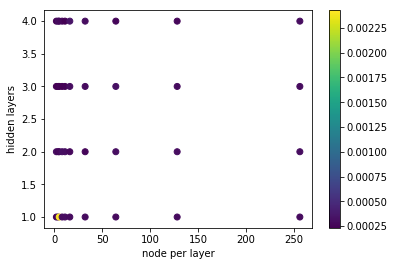

In [29]:
plt.scatter(node_per_layer_list, hidden_layer_list, c=eval_metric_list)
plt.xlabel('node per layer')
plt.ylabel('hidden layers')
plt.colorbar()
plt.show()

In [31]:
min_indx = np.argmin(eval_metric_list)
node_per_layer = node_per_layer_list[min_indx]
hidden_layer = hidden_layer_list[min_indx]
print(min_indx, node_per_layer, hidden_layer)


modl = Sequential()
modl.add(Dense(node_per_layer, kernel_initializer='normal', input_dim=2, activation='relu'))

# hidden layer
for k in range(hidden_layer):
    modl.add(Dense(node_per_layer, kernel_initializer='normal', activation='relu'))

modl.add(Dense(60, kernel_initializer='normal', activation='linear'))
modl.compile(loss='mean_absolute_error', optimizer='adam',
             metrics=['mean_absolute_percentage_error'])

# train it
modl.fit(input_, output_, epochs=10, validation_split=0.2)


eval_metric = modl.evaluate(test_input, answer)

modl.summary()

# see the results of first assembly
z = modl.predict(test_input)
print('\n\n\n')
for indx, val in enumerate(list(train_dat)[3:]):
    err = (answer[0][indx] - z[0][indx]) / answer[0][indx]
    print(val, '\t', z[0][indx], '\t', answer[0][indx], '\t', err, '\n')


3 2 4
Train on 50456 samples, validate on 12614 samples
Epoch 1/10
50456/50456 [==============================] - 19s 381us/step - loss: 0.0051 - mean_absolute_percentage_error: 39159.0654 - val_loss: 2.3063e-04 - val_mean_absolute_percentage_error: 21054.5362
Epoch 2/10
50456/50456 [==============================] - 14s 272us/step - loss: 2.3259e-04 - mean_absolute_percentage_error: 38616.9751 - val_loss: 2.3882e-04 - val_mean_absolute_percentage_error: 14539.6504
Epoch 3/10
50456/50456 [==============================] - 13s 248us/step - loss: 2.3320e-04 - mean_absolute_percentage_error: 38712.5435 - val_loss: 2.2428e-04 - val_mean_absolute_percentage_error: 28565.5393
Epoch 4/10
50456/50456 [==============================] - 14s 278us/step - loss: 2.3272e-04 - mean_absolute_percentage_error: 38698.3454 - val_loss: 2.1318e-04 - val_mean_absolute_percentage_error: 10875.0542
Epoch 5/10
50456/50456 [==============================] - 13s 265us/step - loss: 2.3251e-04 - mean_absolute_perc

In [ ]:
# try fitting linear regression to all fp:
category

============================================================
============================================================
============================================================
============================================================
============================================================
============================================================
============================================================
============================================================
============================================================
============================================================


In [ ]:
from sklearn import model_selection

In [ ]:
validation_size = 0.2
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size=validation_size, random_state=420 )

In [ ]:
def fit_and_test(model, x_train, x_val, y_train, y_val, train_dat):
    model.fit(x_train, y_train)
    predicted_df = pd.DataFrame(model.predict(x_val), columns=train_dat.columns.values[4:], index=x_val.index)
    indices = predicted_df.index
    error_dict = {}
    for indx in indices:
        est = predicted_df.loc[indx]
        actual = y_val.loc[indx]
        percent_err = (est-actual) / actual
        error_dict[indx] = percent_err
    error_df = pd.DataFrame.from_dict(error_dict, orient='index', columns=train_dat.columns.values[4:])
    
    err = []
    isotopes = []
    for isotope in error_df.columns.values:
        isotopes.append(isotope)
        err.append(np.mean(error_df[isotope].values) * 100)
    for indx, val in enumerate(isotopes):
        print(val, err[indx])
        

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
fit_and_test(lm, x_train, x_val, y_train, y_val, train_dat)


In [ ]:
from sklearn import svm
clf = svm.SVR()
fit_and_test(clf, np.array(x_train), x_val, np.array(y_train), y_val, train_dat)


In [ ]:
from sklearn import svm
feature = np.array(x_train)
target = np.array(y_train)
clf_dict = {}
isotopes = train_dat.columns.values[4:]
for indx, isotope in enumerate(isotopes):
    iso_target = target[:,indx]
    clf_dict[isotope] = svm.SVR().fit(feature, iso_target)

clf_dict

In [ ]:
# get all the enr, bu values
# for every isotope run the associated svr, get error

x_ar = np.array(x_val)
err_dict = {}
for key, val in clf_dict.items():
    isotope_arr = np.array(y_val[key])
    predicted = val.predict(x_ar)
    err = (predicted - isotope_arr) / isotope_arr
    err_dict[key] = np.mean(err)

for key, val in err_dict.items():
    print(key, val)